In [146]:
import torch
import numpy as np
from torch import nn, optim
from torch.distributions import Normal, Bernoulli
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

In [2]:
LOGPI = np.log(np.pi)

In [140]:
class HarmonicTrialFunction(nn.Module):
    def __init__(self, alpha):
        super(HarmonicTrialFunction, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
    
    def forward(self, x):
        # outputs logprob
        # 2.0 * because it's |\Psi|^2
        return 2.0 * ( 0.5*torch.log(self.alpha) - 0.25*LOGPI - 0.5*x*x*self.alpha*self.alpha )

    def local_energy(self, x):
        return self.alpha*self.alpha + (x*x) * (1.0 - self.alpha**4.0)

In [141]:
class HydrogenTrialWavefunction(nn.Module):
    def __init__(self, alpha):
        super(HydrogenTrialWavefunction, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
    
    def forward(self, x):
        # outputs logprob
        # 2.0 * because it's |\Psi|^2
        return 2.0 * ( torch.log(self.alpha) + torch.log(x) - self.alpha*x )

    def local_energy(self, x):
        return -(1.0/x) - (self.alpha /2)*(self.alpha - (2.0/x))

$$\log |\Psi(x)|^2$$

In [4]:
def true_mean_energy(alpha):
    return ((alpha**2)/2) + (1.0/(2*(alpha**2)))
def true_variance(alpha):
    return ((alpha**4 - 1)**2)/(2*alpha**4)

In [5]:
def normal_proposal(old_point):
    # symmetric
    return Normal(old_point, 0.3*torch.ones_like(old_point)).sample()

In [114]:
def clip_normal_proposal(old_point):
    samp = Normal(old_point, 0.3*torch.ones_like(old_point)).sample()
    samp.clamp_min_(0.0)
    return samp

In [49]:
def symmetric_mh_acceptance_ratio(logprob, old_config, new_config):
    logacc = torch.min(torch.tensor(0.0), logprob(new_config) - logprob(old_config))
    return torch.exp(logacc)

def asymmetric_mh_acceptance_ratio(logprob, new_old_logprob, old_new_logprob, old_config, new_config):
    logacc = torch.min(torch.tensor(0.0), logprob(new_config) + 
                       old_new_logprob
                       - logprob(old_config)
                      - new_old_logprob)
    return torch.exp(logacc)

In [50]:
# def metropolis(trialfunc, proposal,num_steps=100):
#     config = torch.zeros(1)
#     all_configs = []
#     for step in range(num_steps):
#         next_config = proposal(config)
#         with torch.no_grad():
#             acc = mh_acceptance_ratio(trialfunc, config, next_config)
#         rand_val = np.random.rand()
#         if rand_val <= acc:
#             config = next_config
#         all_configs.append(config.clone()) # can we skip clone here?
#     return torch.stack(all_configs)

In [129]:
def metropolis_symmetric(trialfunc, proposal, num_walkers=2,num_steps=100, init_val=0.0):
    # with more walkers
    # design choice: walkers are always the batch dim
    config = torch.full((num_walkers, 1), init_val)
    all_configs = []
    for step in tqdm(range(num_steps)):
        next_config = proposal(config)
        with torch.no_grad():
            acc = symmetric_mh_acceptance_ratio(trialfunc, config, next_config)
        # acc shape should be (num_walkers, 1)
            accept_or_reject = Bernoulli(acc).sample() # accept is 1, reject is 0
            config = accept_or_reject*next_config + (1.0 - accept_or_reject)*config
            all_configs.append(config.clone()) # can we skip clone here?
    return torch.stack(all_configs, dim=1) # dim=1 to make walkers be the batch dim

In [52]:
def metropolis_asymmetric(trialfunc, proposal, num_walkers=2,num_steps=100):
    # with more walkers
    # design choice: walkers are always the batch dim
    config = torch.zeros(num_walkers, 1)
    all_configs = []
    for step in range(num_steps):
        next_config, next_current_logprob, current_next_logprob = proposal(config)
        with torch.no_grad():
            acc = asymmetric_mh_acceptance_ratio(trialfunc, 
                                                 next_current_logprob, 
                                                 current_next_logprob,
                                                 config, next_config)
            # acc shape should be (num_walkers, 1)
            accept_or_reject = Bernoulli(acc).sample() # accept is 1, reject is 0
            config = accept_or_reject*next_config + (1.0 - accept_or_reject)*config
            all_configs.append(config.clone()) # can we skip clone here?
    return torch.stack(all_configs, dim=1) # dim=1 to make walkers be the batch dim

In [53]:
def unadjusted_langevin(trialfunc, num_walkers=2, num_steps=100, eta=0.01):
    # seems hard to get this to converge
    config = torch.zeros(num_walkers, 1, requires_grad=True)
    grad_out = torch.ones_like(config, requires_grad=False)
    brownian_dist = Normal(torch.zeros_like(config, requires_grad=False),
                          torch.ones_like(config, requires_grad=False))
    all_configs = []
    for step in range(num_steps):
        # next config is from Langevin proposal (grad of logprob + gaussian noise)
        curr_config_logprobs = trialfunc(config)
        grads, = torch.autograd.grad(curr_config_logprobs,
                                    config,
                                    grad_outputs=grad_out,
                                    retain_graph=False)
        with torch.no_grad():
            next_config = config + eta*grads + np.sqrt(2.0*eta)*brownian_dist.sample()
        # then just append
        next_config.requires_grad_(True)
        all_configs.append(next_config)
        config = next_config
    return torch.stack(all_configs, dim=1)

In [54]:
def unadjusted_langevin(trialfunc, num_walkers=2, num_steps=100, eta=0.01):
    # seems hard to get this to converge
    config = torch.zeros(num_walkers, 1, requires_grad=True)
    grad_out = torch.ones_like(config, requires_grad=False)
    all_configs = []
    for step in range(num_steps):
        # next config is from Langevin proposal (grad of logprob + gaussian noise)
        curr_config_logprobs = trialfunc(config)
        grads, = torch.autograd.grad(curr_config_logprobs,
                                    config,
                                    grad_outputs=grad_out,
                                    retain_graph=False)
        with torch.no_grad():
            propdist = Normal(config + eta*grads, np.sqrt(2.0*eta))
            next_config = propdist.sample()
        # then just append
        next_config.requires_grad_(True)
        all_configs.append(next_config)
        config = next_config
    return torch.stack(all_configs, dim=1)

In [55]:
def mala(trialfunc, num_walkers=2, num_steps=100, eta=0.01):
    # this isn't right -- we need different MH filter for asymmetric proposal
    config = torch.zeros(num_walkers, 1)
    grad_out = torch.ones_like(config, requires_grad=False)
    brownian_dist = Normal(torch.zeros_like(config, requires_grad=False),
                          torch.ones_like(config, requires_grad=False))


    def mala_proposal(old_point):
        # 
        old_point.requires_grad_(True)
        curr_config_logprobs = trialfunc(old_point)
        grads, = torch.autograd.grad(curr_config_logprobs,
                                    old_point,
                                    grad_outputs=grad_out,
                                    retain_graph=False)
        with torch.no_grad():
            propdist = Normal(old_point + eta*grads, np.sqrt(2.0*eta))
            next_config = propdist.sample()
            new_old_logprob = propdist.log_prob(next_config)
        next_config.requires_grad_(True)
        next_config_logprobs = trialfunc(next_config)
        next_grads, = torch.autograd.grad(next_config_logprobs,
                                    next_config,
                                    grad_outputs=grad_out,
                                    retain_graph=False)
        with torch.no_grad():
            reverse_propdist = Normal(next_config + eta*next_grads, np.sqrt(2.0*eta))
            old_new_logprob = reverse_propdist.log_prob(old_point)
        return next_config, new_old_logprob, old_new_logprob
    
    return metropolis_asymmetric(trialfunc, mala_proposal, num_walkers=num_walkers, num_steps=num_steps)





In [56]:
def energy_minimize_step(trialfunc, samples, optimizer):
    with torch.no_grad():
        local_energies = trialfunc.local_energy(samples)
    sample_logprobs = trialfunc(samples)
    loss = (local_energies * sample_logprobs).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

$$\nabla \mathbb{E}[f(x)] = \mathbb{E}[f(x) \nabla \log \pi(x)]$$

In [130]:
tf = HarmonicTrialFunction(torch.tensor(1.2))

In [131]:
results = metropolis_symmetric(tf, normal_proposal, num_walkers=100, num_steps=20000)

100%|██████████| 20000/20000 [00:03<00:00, 5121.11it/s]


In [132]:
true_mean_energy(1.2)

1.067222222222222

In [133]:
torch.mean(tf.local_energy(results))

tensor(1.0649, grad_fn=<MeanBackward0>)

In [59]:
results = mala(tf, num_walkers=100, num_steps=20000, eta=0.01)

In [60]:
torch.mean(tf.local_energy(results))

tensor(1.0649, grad_fn=<MeanBackward0>)

In [90]:
def vmc_iterate(tf, num_iters=100):
    opt = optim.SGD(tf.parameters(), lr=1e-2,momentum=0.9)
    for i in range(num_iters):
        results=metropolis_symmetric(tf, normal_proposal, num_walkers=1000, num_steps=5000)
        energy_minimize_step(tf, results, opt)
        print(tf.alpha)

In [117]:
tf = HydrogenTrialWavefunction(torch.tensor(1.0))

In [118]:
results = metropolis_symmetric(tf, clip_normal_proposal, num_walkers=10, num_steps=10000, init_val=0.5)

In [121]:
torch.mean(tf.local_energy(results))

tensor(-0.5000, grad_fn=<MeanBackward0>)

In [142]:
def harmonic_energy_alpha_values():
    vals = np.arange(0.2,1.5,0.1)
    means = []
    for alpha_val in vals:
        print(alpha_val)
        tf = HarmonicTrialFunction(alpha_val)
        samples = metropolis_symmetric(tf, normal_proposal, num_walkers=100, num_steps=20000)
        means.append(torch.mean(tf.local_energy(samples)).item())
    return vals, means

In [143]:
vals, means = harmonic_energy_alpha_values()

  2%|▏         | 429/20000 [00:00<00:04, 4287.56it/s]

0.2


  2%|▏         | 471/20000 [00:00<00:04, 4704.40it/s]

0.30000000000000004


  5%|▍         | 940/20000 [00:00<00:04, 4667.21it/s]

0.4000000000000001


  5%|▍         | 925/20000 [00:00<00:04, 4434.16it/s]

0.5000000000000001


  5%|▍         | 938/20000 [00:00<00:04, 4654.69it/s]

0.6000000000000001


  2%|▏         | 465/20000 [00:00<00:04, 4649.49it/s]

0.7000000000000002


  2%|▏         | 478/20000 [00:00<00:04, 4779.09it/s]

0.8000000000000003


  5%|▍         | 973/20000 [00:00<00:03, 4793.35it/s]

0.9000000000000001


  2%|▏         | 437/20000 [00:00<00:04, 4364.21it/s]

1.0000000000000002


  5%|▍         | 918/20000 [00:00<00:04, 4476.68it/s]

1.1000000000000003


  2%|▏         | 470/20000 [00:00<00:04, 4693.19it/s]

1.2000000000000004


  5%|▍         | 963/20000 [00:00<00:03, 4795.76it/s]

1.3000000000000003


  2%|▏         | 487/20000 [00:00<00:04, 4862.21it/s]

1.4000000000000004


100%|██████████| 20000/20000 [00:03<00:00, 5294.09it/s]


Text(0, 0.5, 'mean energy')

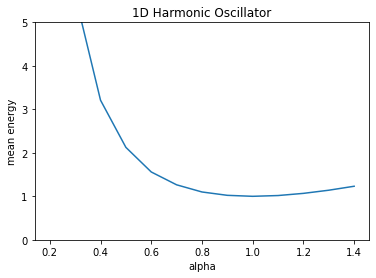

In [152]:
plt.plot(vals, means)
plt.ylim(0,5)
plt.title("1D Harmonic Oscillator")
plt.xlabel("alpha")
plt.ylabel("mean energy")

In [154]:
def hydrogen_energy_alpha_values():
    vals = np.arange(0.2,1.5,0.1)
    means = []
    for alpha_val in vals:
        print(alpha_val)
        tf = HydrogenTrialWavefunction(alpha_val)
        samples = metropolis_symmetric(tf, clip_normal_proposal, num_walkers=100, num_steps=20000, init_val=0.5)
        means.append(torch.mean(tf.local_energy(samples)).item())
    return vals, means

In [155]:
vals, means = hydrogen_energy_alpha_values()

  5%|▌         | 1042/20000 [00:00<00:03, 4807.27it/s]

0.2


  2%|▏         | 407/20000 [00:00<00:04, 4065.12it/s]

0.30000000000000004


  6%|▌         | 1112/20000 [00:00<00:03, 5355.25it/s]

0.4000000000000001


  3%|▎         | 555/20000 [00:00<00:03, 5541.97it/s]

0.5000000000000001


  6%|▌         | 1144/20000 [00:00<00:03, 5595.19it/s]

0.6000000000000001


  6%|▌         | 1106/20000 [00:00<00:03, 5472.69it/s]

0.7000000000000002


  6%|▌         | 1164/20000 [00:00<00:03, 5711.93it/s]

0.8000000000000003


  2%|▏         | 429/20000 [00:00<00:04, 4286.30it/s]

0.9000000000000001


  5%|▌         | 1066/20000 [00:00<00:03, 5193.24it/s]

1.0000000000000002


  3%|▎         | 521/20000 [00:00<00:03, 5202.67it/s]

1.1000000000000003


  5%|▌         | 1083/20000 [00:00<00:03, 5266.78it/s]

1.2000000000000004


  6%|▌         | 1110/20000 [00:00<00:03, 5331.66it/s]

1.3000000000000003


  5%|▌         | 1084/20000 [00:00<00:03, 5339.81it/s]

1.4000000000000004


100%|██████████| 20000/20000 [00:03<00:00, 6035.09it/s]


Text(0, 0.5, 'mean energy')

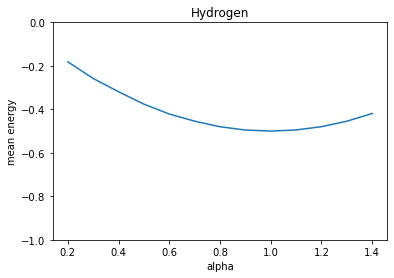

In [156]:
plt.plot(vals, means)
plt.ylim(-1,0)
plt.title("Hydrogen")
plt.xlabel("alpha")
plt.ylabel("mean energy")